In [1]:
#get larlite
from larlite import larlite as ll
from larlite import larutil as lu

geo=lu.Geometry.GetME()
geoH=lu.GeometryHelper.GetME()

import ROOT

#graphics 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
import root_numpy as rn
import pandas as pd
import cv2

matplotlib.rcParams['font.size'] = 20
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.weight'] = 'bold'
matplotlib.rcParams['xtick.labelsize'] = 16
matplotlib.rcParams['ytick.labelsize'] = 16

%matplotlib inline

/Library/Python/2.7/site-packages/root_numpy/__init__.py:46: RuntimeWarning: numpy 1.12.1 is currently installed but you installed root_numpy against numpy 1.8.0rc1. Please consider reinstalling root_numpy for this numpy version.
  RuntimeWarning)


In [2]:
#create storage manager
sm = ll.storage_manager()
sm.set_io_mode(ll.storage_manager.kREAD)
#FILENAME='/Volumes/UBooNEDataMCC8/MCC8_3/OutputFiles/MCBNBCos/pi0_out.root'
FILENAME='/Users/ah673/WorkArea/Root6LArLite/UserDev/LArOpenCV/App/mac/image_output.root'

sm.add_in_filename(FILENAME)
sm.open()

True

In [31]:
#plt.figure()
#counts = plt.hist2d(phits.Wire,phits.PeakTime,bins=(15,28))
#px = geoH.Point_3Dto2D(vtx.data(),plane)
#pt=np.array([px.w/geoH.WireToCm(),px.t//geoH.TimeToCm()+800.0])
#plt.plot(pt[0],pt[1],'*',markersize=20,color='yellow')


In [95]:
evt = 7
sm.go_to(evt)

event_hits     = sm.get_data(ll.data.kHit,"gaushit")
event_clusters = sm.get_data(ll.data.kCluster,"ImageClusterHit")
event_ass      = sm.get_data(ll.data.kAssociation,"ImageClusterHit")
cluster_to_hit_ass = event_ass.association(event_clusters.id(),event_hits.id())
event_vertex = sm.get_data(ll.data.kVertex,"mcvertex")
event_user = sm.get_data(ll.data.kUserInfo,"ImageClusterHit")
gausdata = rn.root2array(FILENAME,
                            treename='hit_gaushit_tree',
                            branches=['hit_gaushit_branch.vector<larlite::hit>.fPeakTime',
                                      'hit_gaushit_branch.vector<larlite::hit>.fWireID.Wire',
                                      'hit_gaushit_branch.vector<larlite::hit>.fWireID.Plane'])

hits_df= pd.DataFrame({'Wire'      : gausdata[evt][1],
                           'PeakTime'  : gausdata[evt][0],
                           'Plane'     : gausdata[evt][2]})

    
#User info contains lots of stuff, but lets filter it by ID string
sbcplane0 = [event_user[s] for s in xrange(event_user.size()) if event_user[s].get_string("ID") == 'Algo_pc_Plane_0_clusters'][0]
sbcplane1 = [event_user[s] for s in xrange(event_user.size()) if event_user[s].get_string("ID") == 'Algo_pc_Plane_1_clusters'][0]
sbcplane2 = [event_user[s] for s in xrange(event_user.size()) if event_user[s].get_string("ID") == 'Algo_pc_Plane_2_clusters'][0]
    
#User info contains lots of stuff, but lets filter it by ID string
plane0 = [event_user[s] for s in xrange(event_user.size()) if event_user[s].get_string("ID") == 'Algo_cwo_Plane_0_clusters'][0]
plane1 = [event_user[s] for s in xrange(event_user.size()) if event_user[s].get_string("ID") == 'Algo_cwo_Plane_1_clusters'][0]
plane2 = [event_user[s] for s in xrange(event_user.size()) if event_user[s].get_string("ID") == 'Algo_cwo_Plane_2_clusters'][0]
 
#convex hull per cluster
roiplane0 = [event_user[s] for s in xrange(event_user.size()) if event_user[s].get_string("ID") == 'Algo_cwo_Plane_0_roi_bounds'][0]
roiplane1 = [event_user[s] for s in xrange(event_user.size()) if event_user[s].get_string("ID") == 'Algo_cwo_Plane_1_roi_bounds'][0]
roiplane2 = [event_user[s] for s in xrange(event_user.size()) if event_user[s].get_string("ID") == 'Algo_cwo_Plane_2_roi_bounds'][0] 

plane = 2 
sbc_data=event_user[plane]
hsv = plt.get_cmap('jet')
lors = hsv(np.linspace(0, 1.0, cluster_to_hit_ass.size()))

vtx=ROOT.std.vector('double')()
vtx.resize(3)
vtx[0]=event_vertex[0].X()
vtx[1]=event_vertex[0].Y()
vtx[2]=event_vertex[0].Z()

exec("roi_data = roiplane%s"%plane)  
bbx=np.array(roi_data.get_darray('roi_bounds_x'))
bby=np.array(roi_data.get_darray('roi_bounds_y'))

phits = hits_df.query("Plane=={}".format(plane))

xmax = phits.Wire.max() 
ymax = int(phits.PeakTime.max()) 

In [96]:
print geoH.TimeToCm() #[cm/tick]
print geoH.WireToCm() # [cm/wire]

0.0557179413736
0.300000011921


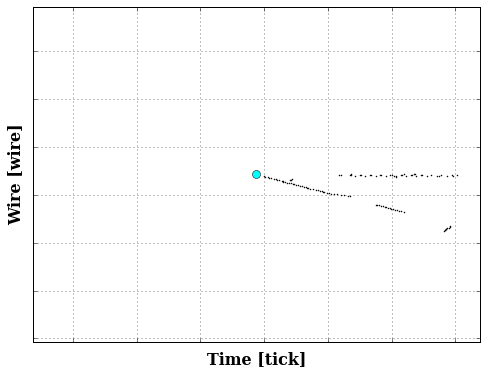

In [156]:
counts, bins, _ = np.histogram2d(phits.Wire,phits.PeakTime,bins=(xmax,ymax),range=((0,xmax+1),(0,ymax+1)))
px = geoH.Point_3Dto2D(vtx.data(),plane)
center = (px.t//geoH.TimeToCm()+800.0,px.w/geoH.WireToCm())
rad =  350 #(bby.max() - bby.min())
out = cv2.linearPolar(counts, center, int(rad), cv2.WARP_FILL_OUTLIERS)


fig,ax=plt.subplots(figsize=(8,6))

ax.set_yticklabels([])
ax.set_xticklabels([])

plt.plot(phits.PeakTime,phits.Wire,'o',color='black',markersize=1)#,alpha=0.2)   
plt.plot(center[0],center[1],'o',markersize=8,color='cyan')
#plt.gca().invert_yaxis()
plt.ylim(pt[0] - rad, pt[0] + rad)    
plt.xlim(pt[1] - rad, pt[1] + rad)  

ax.invert_yaxis()
plt.grid()

plt.xlabel('Time [tick]',fontsize=16,weight='bold')
plt.ylabel('Wire [wire]',fontsize=16,weight='bold')
#plt.axhline(259)

(1022,)
(1022,)


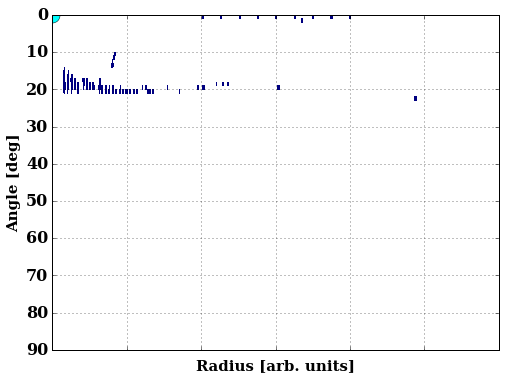

In [157]:
xedges = [i for i in xrange(ymax)]
yedges = [i for i in xrange(xmax)]
Hmasked = np.ma.masked_where(out==0,out) # Mask pixels with a value of zero
print Hmasked[Hmasked!=0].shape
print out[out!=0].shape

fig,ax=plt.subplots(figsize=(8,6))
plt.pcolormesh(xedges,yedges,Hmasked) #[:xlim][:ylim])
plt.ylim(0,90)
plt.gca().invert_yaxis()
ax.set_xticklabels([])
plt.ylabel('Angle [deg]',fontsize=15,weight='bold')
plt.xlabel('Radius [arb. units]',fontsize=15,weight='bold')
plt.plot(0,0,'o',markersize=15,color='cyan')
plt.grid(True)
#print Hmasked[Hmasked != 0]

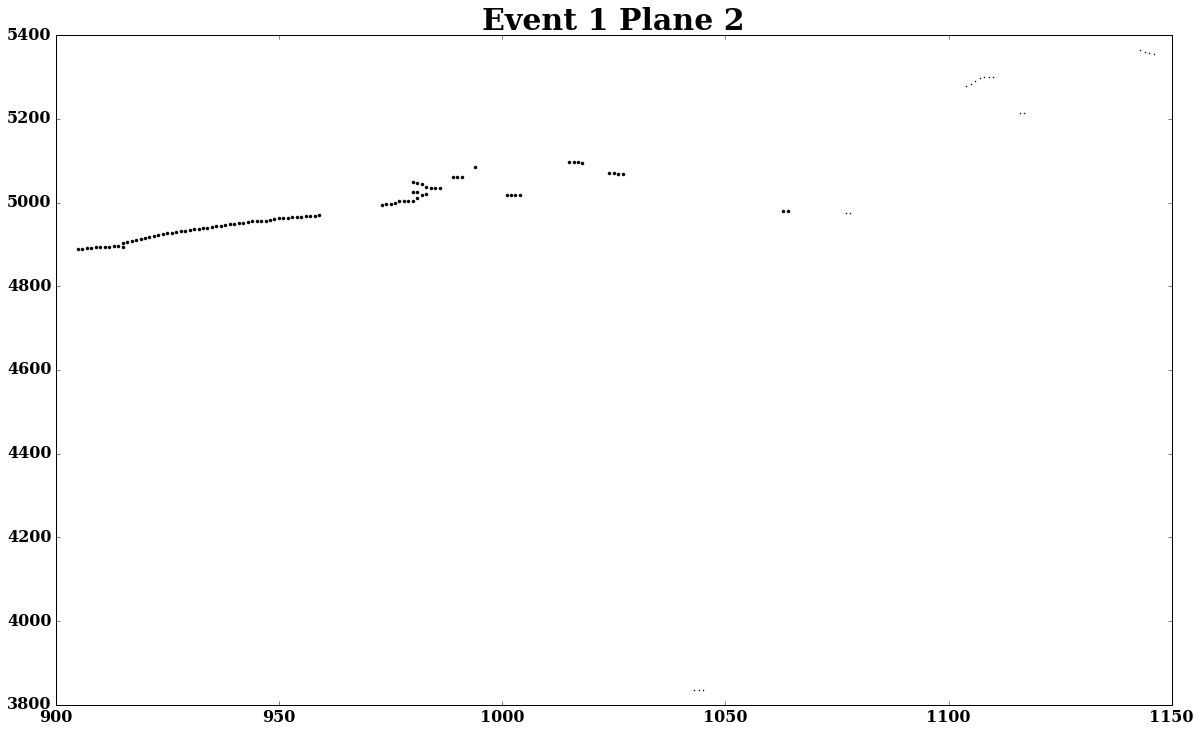

In [22]:
while True:
    evt = 1
    sm.go_to(evt)

    #get hits and clusters
    event_hits     = sm.get_data(ll.data.kHit,"gaushit")
    event_clusters = sm.get_data(ll.data.kCluster,"ImageClusterHit")
    event_ass      = sm.get_data(ll.data.kAssociation,"ImageClusterHit")
    cluster_to_hit_ass = event_ass.association(event_clusters.id(),event_hits.id())
    event_vertex = sm.get_data(ll.data.kVertex,"mcvertex")
    event_user = sm.get_data(ll.data.kUserInfo,"ImageClusterHit")
    gausdata = rn.root2array(FILENAME,
                            treename='hit_gaushit_tree',
                            branches=['hit_gaushit_branch.vector<larlite::hit>.fPeakTime',
                                      'hit_gaushit_branch.vector<larlite::hit>.fWireID.Wire',
                                      'hit_gaushit_branch.vector<larlite::hit>.fWireID.Plane'])

    hits_df= pd.DataFrame({'Wire'      : gausdata[evt][1],
                           'PeakTime'  : gausdata[evt][0],
                           'Plane'     : gausdata[evt][2]})

    
    #User info contains lots of stuff, but lets filter it by ID string
    sbcplane0 = [event_user[s] for s in xrange(event_user.size()) if event_user[s].get_string("ID") == 'Algo_pc_Plane_0_clusters'][0]
    sbcplane1 = [event_user[s] for s in xrange(event_user.size()) if event_user[s].get_string("ID") == 'Algo_pc_Plane_1_clusters'][0]
    sbcplane2 = [event_user[s] for s in xrange(event_user.size()) if event_user[s].get_string("ID") == 'Algo_pc_Plane_2_clusters'][0]
    
    #User info contains lots of stuff, but lets filter it by ID string
    plane0 = [event_user[s] for s in xrange(event_user.size()) if event_user[s].get_string("ID") == 'Algo_cwo_Plane_0_clusters'][0]
    plane1 = [event_user[s] for s in xrange(event_user.size()) if event_user[s].get_string("ID") == 'Algo_cwo_Plane_1_clusters'][0]
    plane2 = [event_user[s] for s in xrange(event_user.size()) if event_user[s].get_string("ID") == 'Algo_cwo_Plane_2_clusters'][0]
 
    #convex hull per cluster
    roiplane0 = [event_user[s] for s in xrange(event_user.size()) if event_user[s].get_string("ID") == 'Algo_cwo_Plane_0_roi_bounds'][0]
    roiplane1 = [event_user[s] for s in xrange(event_user.size()) if event_user[s].get_string("ID") == 'Algo_cwo_Plane_1_roi_bounds'][0]
    roiplane2 = [event_user[s] for s in xrange(event_user.size()) if event_user[s].get_string("ID") == 'Algo_cwo_Plane_2_roi_bounds'][0]

    #Show the ImageClusters
    for plane in [0,1,2]:
        
        plane = 2 
        sbc_data=event_user[plane]
        hsv = plt.get_cmap('jet')
        lors = hsv(np.linspace(0, 1.0, cluster_to_hit_ass.size()))

        fig,ax=plt.subplots(figsize=(10*2,6*2))

        phits = hits_df.query("Plane=={}".format(plane))

        
        ax.plot(phits.Wire,phits.PeakTime,'o',color='black',markersize=1)#,alpha=0.2)
        
        exec("sbc_data = sbcplane%s"%plane)
        nsbc_clusters = sbc_data.get_int("NClusters")
        
#         for c in xrange(nsbc_clusters):
#             xx=np.array(sbc_data.get_darray('ClusterID_{}_contour_x'.format(c)))
#             yy=np.array(sbc_data.get_darray('ClusterID_{}_contour_y'.format(c)))
#             xx=np.append(xx,xx[0])
#             yy=np.append(yy,yy[0])
#             plt.plot(yy,xx,':',lw=2,color='Grey')
      
        # plot each cluster and userinfo
        for ix,cluster in enumerate(cluster_to_hit_ass):

            ##############################
            #get the hits for this clusters
            slice_=np.array(cluster)
            if event_clusters[ix].Plane().Plane != plane: continue
            if slice_.size == 0: continue

            hslice = hits_df.iloc[slice_]
            ax.plot(hslice.Wire,hslice.PeakTime,'o',color='black',markersize=3)

            ##############################
            #call user_info get_darray, for the contour   
            exec("cluster_data = plane%s"%plane)

            cid = event_clusters[ix].ID()
            xx=np.array(cluster_data.get_darray('ClusterID_{}_contour_x'.format(cid)))
            yy=np.array(cluster_data.get_darray('ClusterID_{}_contour_y'.format(cid)))

            xx=np.append(xx,xx[0])
            yy=np.append(yy,yy[0])

            #plt.plot(yy,xx,'-',lw=2)

            ##############################
        vtx=ROOT.std.vector('double')()
        vtx.resize(3)
        vtx[0]=event_vertex[0].X()
        vtx[1]=event_vertex[0].Y()
        vtx[2]=event_vertex[0].Z()
        px = geoH.Point_3Dto2D(vtx.data(),plane)
        pt=np.array([px.w/geoH.WireToCm(),px.t//geoH.TimeToCm()+800.0])

        #ax.plot(pt[0],pt[1],'*',markersize=15,color='yellow')
            
        exec("roi_data = roiplane%s"%plane)  
        bbx=np.array(roi_data.get_darray('roi_bounds_x'))
        bby=np.array(roi_data.get_darray('roi_bounds_y'))
        
        #img = np.zeros((int(bbx.max() - bbx.min()), int(bby.max() - bby.min()), 1), dtype = "uint8")
        #ax.set_xlim(bbx.min(),bbx.max())
        #ax.set_ylim(bby.min(),bby.max())

        #plt.grid()
        ax.set_title("Event {} Plane {}".format(evt,plane),fontweight='bold',fontsize=30)
        plt.show()
        break
    break

In [57]:
img = np.zeros((256,256,1), dtype = "uint8")
print img

[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]
